In [18]:
import os
from IPython.display import Image as ipy_image
from IPython.display import display

#from utils.demo_util import get_shape_comp_model, get_shape_comp_opt, make_dummy_batch
#from utils.qual_util import load_bert2vqsc_model, get_lang_prob, save_mesh_as_gif
from utils.qual_util import get_lang_prob, save_mesh_as_gif
from utils.util import seed_everything
from utils.util_3d import init_mesh_renderer, sdf_to_mesh
import os
from termcolor import colored, cprint
import torch
import utils.util as util
from tqdm.notebook import tqdm

from datasets.ys_shapeset import  ShapeNetZSets


%reload_ext autoreload
%autoreload 2

In [62]:
seed_everything(111)

description = "New bert model with probs passed as set and in inference with - softmax v1 transformer "
res_dir = 'logs/comparison/v21'
if not os.path.exists(res_dir): os.makedirs(res_dir)

with open(f"{res_dir}/description.txt","w") as f:
    f.write(description)

gpu_id = 0
nimgs=6

class Opt:
    def __init__(self):
        self.name = 'opt'

In [20]:
def load_bert2vqsc_model(opt):
    from models.networks.bert2vq_sc import BERT2VQ
    
    net = BERT2VQ(opt)
    # bert2vq_ckpt = '/home/paritosh/Desktop/Capstone/clean-code/generative_transformers/logs/bert2vq-shapenet_lang-all-LR1e-4-cleanCode-langMode-/ckpt/bert2vq_epoch-145.pth'
    bert2vq_ckpt = '../raw_dataset/checkpoints_new/bert2vq_epoch-latest.pth'
    state_dict = torch.load(bert2vq_ckpt)
    net.load_state_dict(state_dict['bert2vq'])
    net.eval()
    net.to(opt.device)
    
    return net

In [4]:
shapeset = ShapeNetZSets()

In [8]:
y  = shapeset[4]["z_set"]
y.shape


torch.Size([8, 8, 8, 512])

In [21]:
def create_model(opt):
    model = None

    if opt.model == 'pvqvae':
        # vqvae
        from models.pvqvae_model import PVQVAEModel
        model = PVQVAEModel()
    elif opt.model == 'rand_tf':
        # transformer
        from models.rand_tf_model import RandTransformerModel
        model = RandTransformerModel()
    elif opt.model == 'rand_tf_old':
        from models.rand_tf_model_old import RandTransformerModelOld
        model = RandTransformerModelOld()
    elif opt.model == 'seq_tf':
        # seq-transformer
        from models.seq_tf_model import SeqTransformerModel
        model = SeqTransformerModel()
    elif opt.model == 'bert2vq':
        from models.bert2vq_model import BERT2VQModel
        model = BERT2VQModel()
    elif opt.model == "bert2vqsc":
        from models.bert2vq_scmodel import BERT2VQSCModel
        model = BERT2VQSCModel()
    elif opt.model == 'resnet2vq':
        from models.resnet2vq_model import ResNet2VQModel
        model = ResNet2VQModel()
    elif opt.model == 'resnet2vox':
        from models.resnet2vox_model import ResNet2VoxModel
        model = ResNet2VoxModel()
    elif opt.model == 'resnet2sdf':
        from models.resnet2sdf_model import ResNet2SDFModel
        model = ResNet2SDFModel()
    elif opt.model == 'baseline_je':
        from models.baseline_je_model import LangJEModel
        model = LangJEModel()
    elif opt.model == 'img_je':
        from models.img_je_model import ImgJEModel
        model = ImgJEModel()
    else:
        raise ValueError("Model [%s] not recognized." % opt.model)

    model.initialize(opt)
    cprint("[*] Model has been created: %s" % model.name(), 'blue')
    if(opt.ckpt is not None):
        model.load_ckpt(opt.ckpt)
        print("MODEL LOADED")
    return model

In [22]:
def get_shape_comp_opt(gpu_id=0):
    opt = Opt()

    # args
    gpuid=[gpu_id]
    batch_size=1
    max_dataset_size=10000000

    name='test_transformer'

    # default args
    opt.serial_batches = False
    opt.nThreads = 4

    # important args
    opt.dataset_mode = 'shapenet_code'
    opt.seed = 111
    opt.isTrain = False
    opt.gpu_ids = gpuid
    opt.device = 'cuda:%s' % gpuid[0]
    opt.batch_size = batch_size
    opt.max_dataset_size = max_dataset_size

    opt.name = name

    #utils.util.seed_everything(opt.seed)
    opt.phase = 'test'
    return opt




def get_shape_comp_model(opt, model, ckpt):
    
    # load tf stuff
    opt.model=model
    opt.tf_cfg='configs/rand_tf_snet_code.yaml'
    opt.ckpt = ckpt
    
    # load vq stuff
    opt.vq_model='pvqvae'
    opt.vq_cfg='configs/pvqvae_snet.yaml'
    opt.vq_ckpt='../raw_dataset/checkpoints/vqvae.pth'
    
    ### opt.vq_dset='sdf_code' # original
    opt.vq_dset='snet'

    model = create_model(opt)
    print(f'[*] "{opt.model}" initialized.')
    model.load_ckpt(opt.ckpt)
        
    return model

In [63]:
opt = get_shape_comp_opt(gpu_id=gpu_id)
opt.dataset_mode = "text2shape"
modelOld = get_shape_comp_model(opt,"rand_tf_old","../raw_dataset/checkpoints/rand_tf_singles_best.pth")    
modelOld.eval()

#new_checkpoint_path = "logs/valid-valid-with-fusion-rand_tf-owndataset-chair-LR1e-4-clean-with-ckpt/ckpt/rand_tf_epoch-latest.pth"
new_checkpoint_path = "../raw_dataset/checkpoints_new/rand_tf_epoch_latest_fusion_transfer_v1.pth"
#new_checkpoint_path="../raw_dataset/checkpoints_new/rand_tf_epoch_latest_fusion_v2.pth"
#new_checkpoint_path = "../raw_dataset/checkpoints_new/rand_tf_epoch_0_fusion_v3.pth"
modelNew = get_shape_comp_model(opt,"rand_tf",new_checkpoint_path) 
modelNew.eval()



[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: ../raw_dataset/checkpoints/vqvae.pth
[*] Model has been created: Rand-Transformer-Model
[*] weight successfully load from: ../raw_dataset/checkpoints/rand_tf_singles_best.pth
MODEL LOADED
[*] "rand_tf_old" initialized.
[*] weight successfully load from: ../raw_dataset/checkpoints/rand_tf_singles_best.pth
[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: ../raw_dataset/checkpoints/vqvae.pth
[*] Model has been created: Rand-Transformer-Model
[*] weight successfully load from: ../raw_dataset/checkpoints_new/rand_tf_epoch_latest_fusion_transfer_v1.pth
MODEL LOADED
[*] "rand_tf" initialized.
[*] weight successfully load from: ../raw_dataset/checkpoints_new/rand_tf_

In [64]:
""" setup renderer """
dist, elev, azim = 1.7, 20, 20
mesh_renderer = init_mesh_renderer(image_size=256, dist=dist, elev=elev, azim=azim, device=opt.device)

opt.mlp_layers = 3
opt.mlp_hidden = 1024
bert2vq = load_bert2vqsc_model(opt)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
with open("./test_samples_paper.txt") as file:
    sequences = [line.rstrip() for line in file]




In [26]:
sequences_clean = [0] * len(sequences)
for i in range(len(sequences)):
    seq = sequences[i]
    sequence = seq.split(",")
    sequences_clean[i] = sequence

In [27]:
sequences_clean[0]

['a high bar seat',
 'has a molded curved seat',
 'has a metal footrest and circular base']

In [12]:
model = modelOld
model_name = "model_old"

import torch
from utils.qual_util import get_lang_prob_recursive, save_mesh_as_pics
from einops import rearrange

z1 = torch.full((1,8,8,8,512), 1/512).cuda()

test_data = { }
sampler = torch.distributions.categorical.Categorical(z1)
codeix = sampler.sample()
test_data["code"] = z1.repeat_interleave(nimgs, dim=0)
test_data["idx"] = sampler.sample().repeat_interleave(nimgs, axis=0).cpu()
test_data["z_q"] = z1


for sequence in sequences_clean:
    last_text = ""
    for text in sequence:
        all_text = last_text + text
        text_conditional = text
        lang_conditional_prob = get_lang_prob_recursive(bert2vq, text_conditional, z1)
        z1_old = rearrange(z1, 'bs d h w c -> (d h w bs) c')
        z1 = rearrange(lang_conditional_prob, '(d h w) bs c -> bs d h w c', d=8, h=8, w=8)
        gen_order = torch.argsort((torch.abs(lang_conditional_prob[:, 0, :]-z1_old)).sum(-1), dim=-1, descending=True)
        lang_conditional_prob = lang_conditional_prob.repeat(1, nimgs, 1)
        topk = 50
        model.inference(test_data, topk=topk, prob=None,gen_order=None)
        test_data["code"] = z1.repeat_interleave(nimgs, dim=0)
        sampler = torch.distributions.categorical.Categorical(z1)
        test_data["idx"] = torch.cat( [sampler.sample().cpu() for i in range(6)], dim=0)
        print(test_data["idx"].shape)
        gen_mesh = sdf_to_mesh(model.x_recon_tf)
    
        gen_gif_name = f'{res_dir}/{model_name}-{all_text}.gif'
        #import pdb;pdb.set_trace()
        try:
            save_mesh_as_pics(mesh_renderer, gen_mesh, nrow=3, out_name=gen_gif_name)
        except:
            import pdb;pdb.set_trace()
        last_text = text_conditional + " "
        
        print(text_conditional)
        for name in [gen_gif_name]:
            display(ipy_image(name))
        

[*] autoregressively inferencing...:  63%|█████████████████████████████████████████████████▉                             | 324/512 [00:02<00:01, 125.69it/s]


KeyboardInterrupt: 

In [ ]:
torch.randperm(512, device='cuda').shape

  0%|          | 0/13 [00:00<?, ?it/s]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: a high bar seat
Full Text: a high bar seat
Saved: logs/comparison/v21/0-0-model_new-a high bar seat.gif


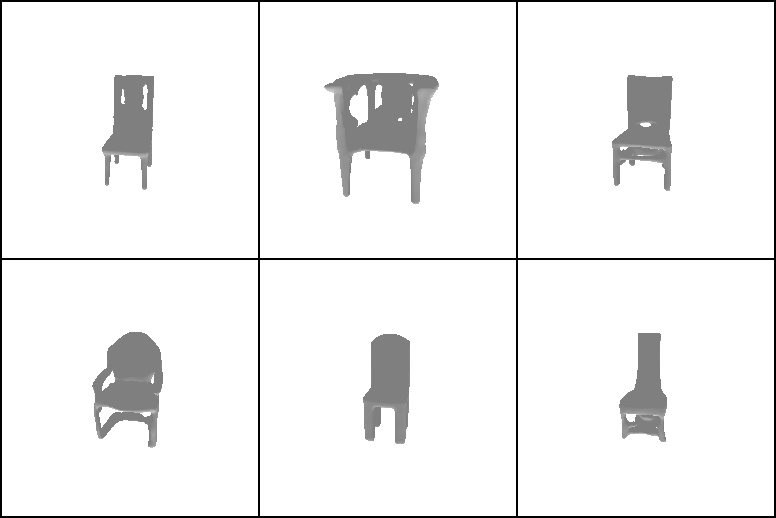

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: has a molded curved seat
Full Text: a high bar seat has a molded curved seat
Saved: logs/comparison/v21/0-1-model_new-a high bar seat has a molded curved seat.gif


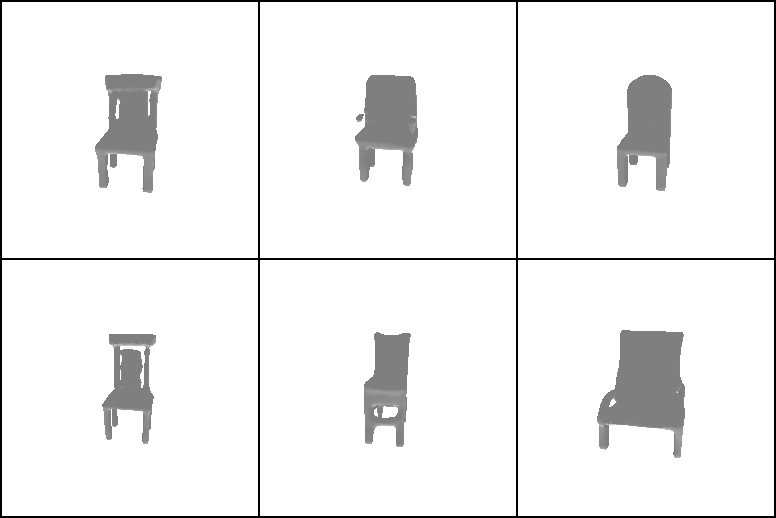

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: has a metal footrest and circular base
Full Text: has a molded curved seat has a metal footrest and circular base
Saved: logs/comparison/v21/0-2-model_new-has a molded curved seat has a metal footrest and circular base.gif


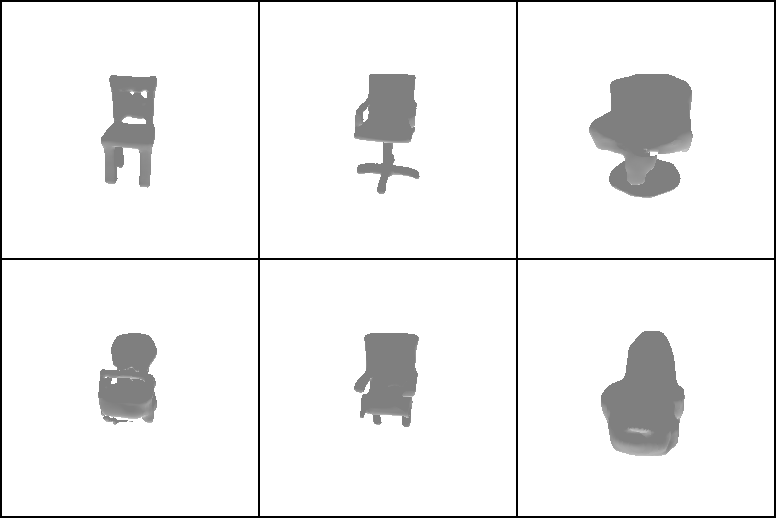

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: a white metallic chair
Full Text: a white metallic chair
Saved: logs/comparison/v21/1-0-model_new-a white metallic chair.gif


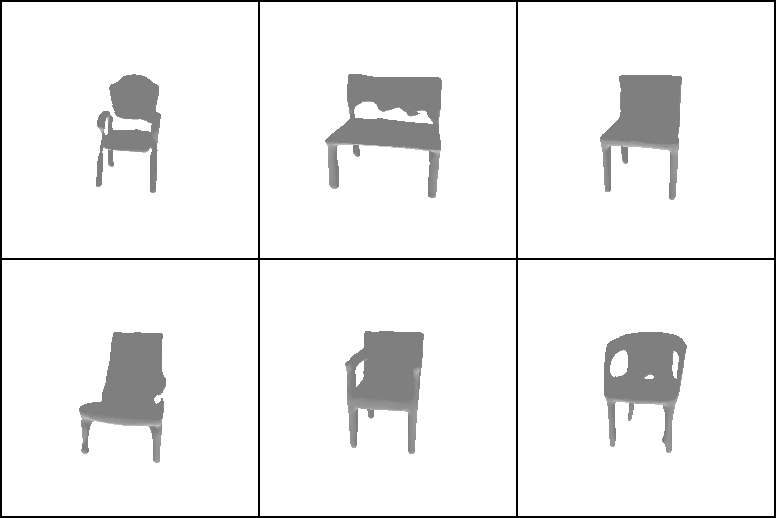

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: with stand legs
Full Text: a white metallic chair with stand legs
Saved: logs/comparison/v21/1-1-model_new-a white metallic chair with stand legs.gif


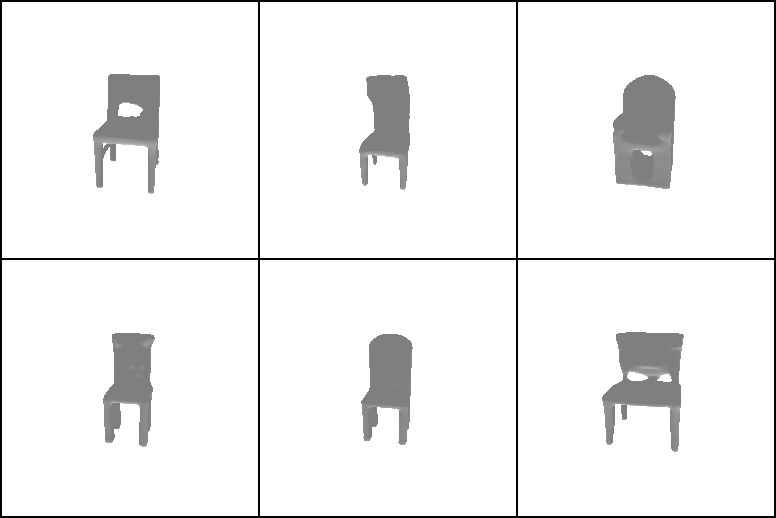

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: and wheels
Full Text: with stand legs and wheels
Saved: logs/comparison/v21/1-2-model_new-with stand legs and wheels.gif


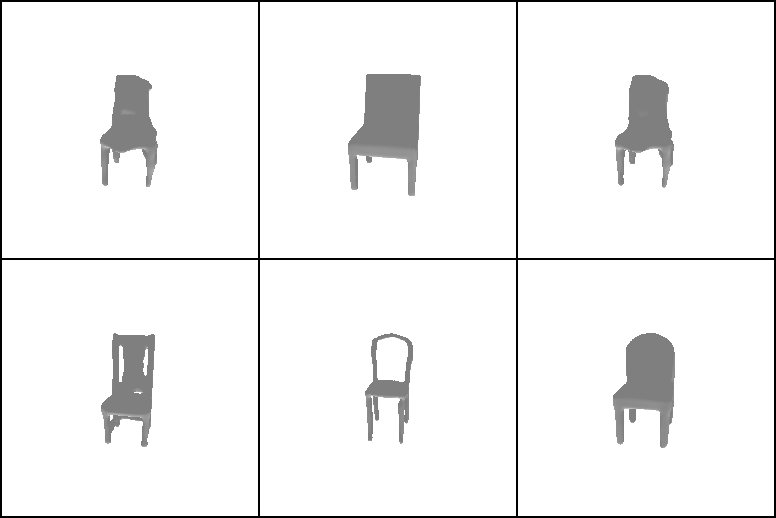

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: wooden chair
Full Text: wooden chair
Saved: logs/comparison/v21/2-0-model_new-wooden chair.gif


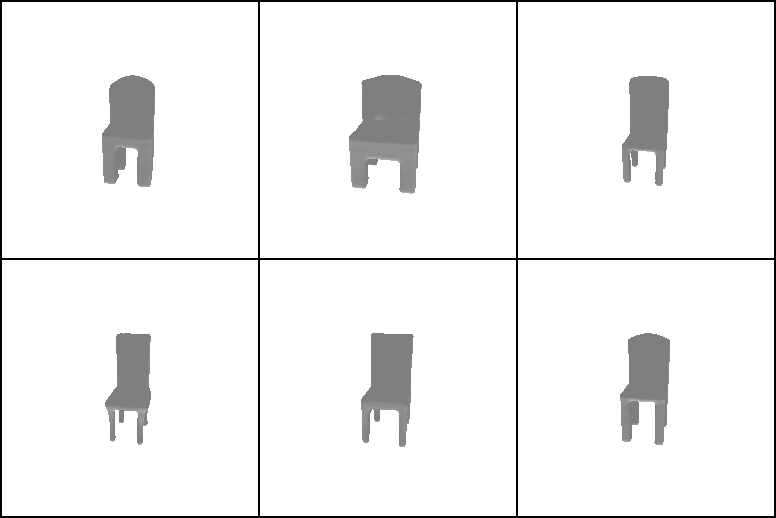

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: with long back
Full Text: wooden chair with long back
Saved: logs/comparison/v21/2-1-model_new-wooden chair with long back.gif


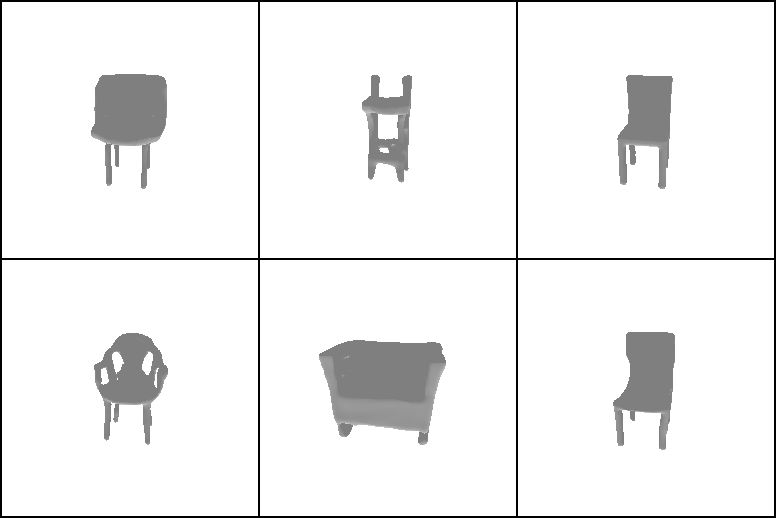

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: and 4 long legs attached at the corners and has no handles
Full Text: with long back and 4 long legs attached at the corners and has no handles
Saved: logs/comparison/v21/2-2-model_new-with long back and 4 long legs attached at the corners and has no handles.gif


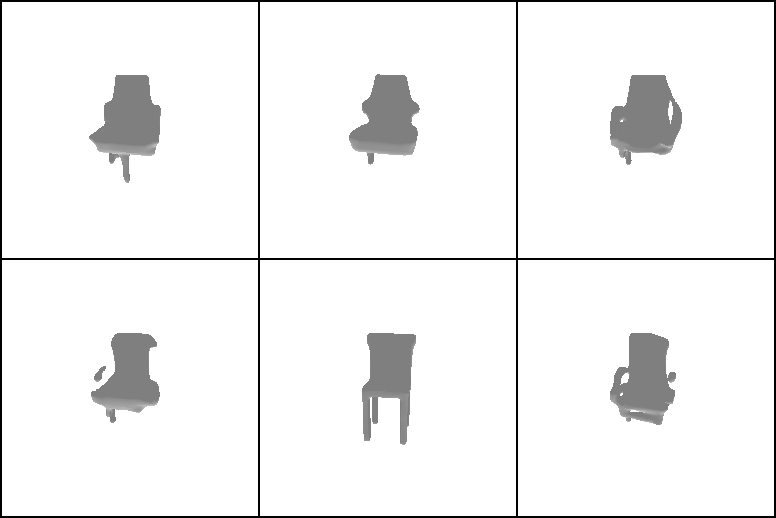

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: the armrests and frame are black
Full Text: the armrests and frame are black
Saved: logs/comparison/v21/3-0-model_new-the armrests and frame are black.gif


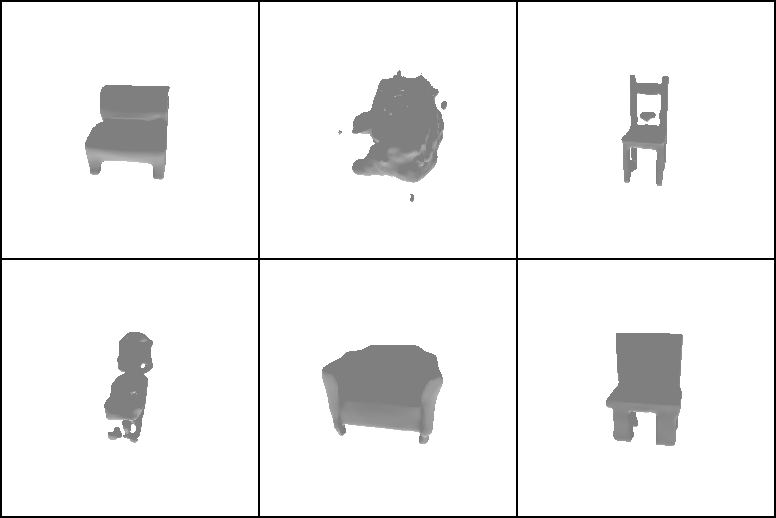

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: and the chair slops slightly backward
Full Text: the armrests and frame are black and the chair slops slightly backward
Saved: logs/comparison/v21/3-1-model_new-the armrests and frame are black and the chair slops slightly backward.gif


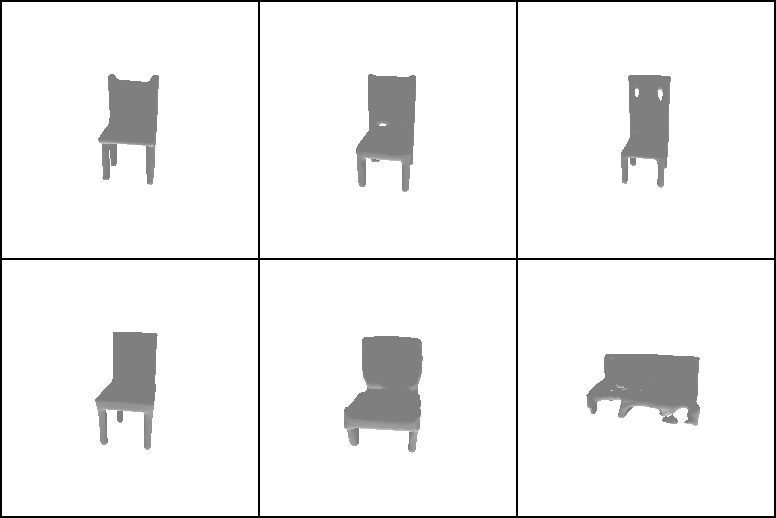

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: A gray sofa with a rectangular cushion and padding
Full Text: and the chair slops slightly backward A gray sofa with a rectangular cushion and padding
Saved: logs/comparison/v21/3-2-model_new-and the chair slops slightly backward A gray sofa with a rectangular cushion and padding.gif


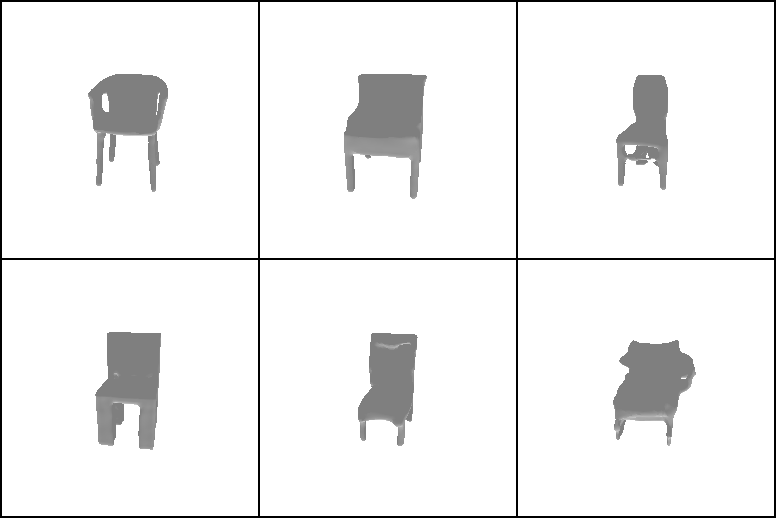

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: A metal chair
Full Text: A metal chair
Saved: logs/comparison/v21/4-0-model_new-A metal chair.gif


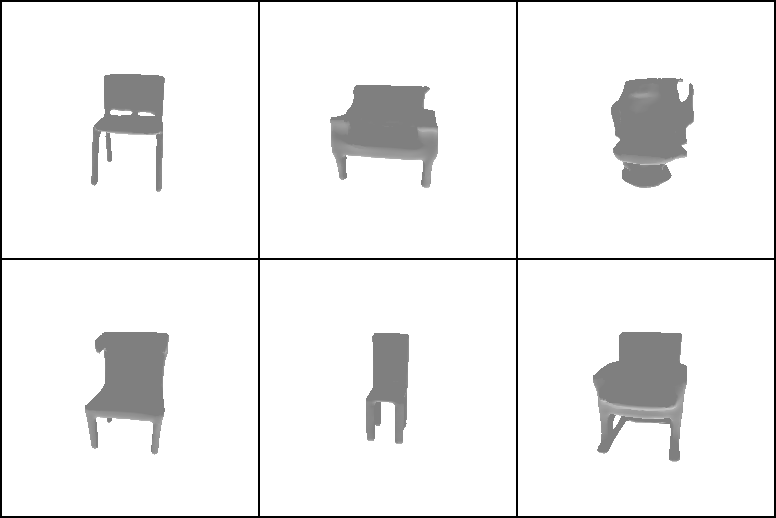

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: with thin legs
Full Text: A metal chair with thin legs
Saved: logs/comparison/v21/4-1-model_new-A metal chair with thin legs.gif


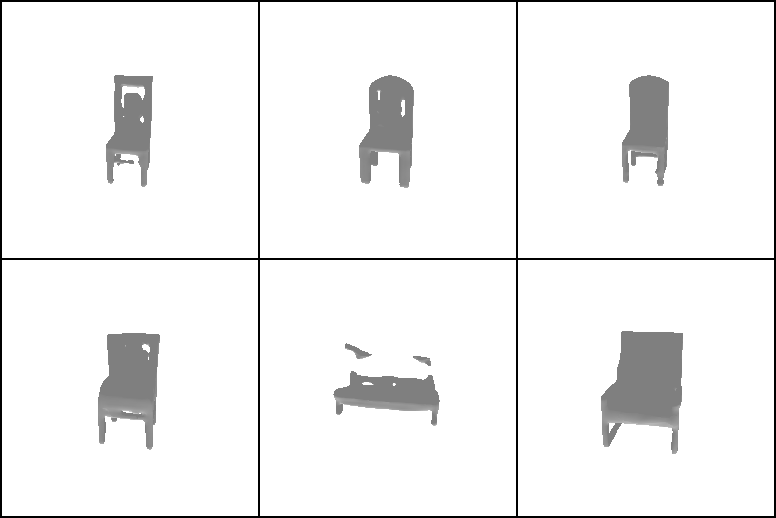

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: and two curved arms
Full Text: with thin legs and two curved arms
Saved: logs/comparison/v21/4-2-model_new-with thin legs and two curved arms.gif


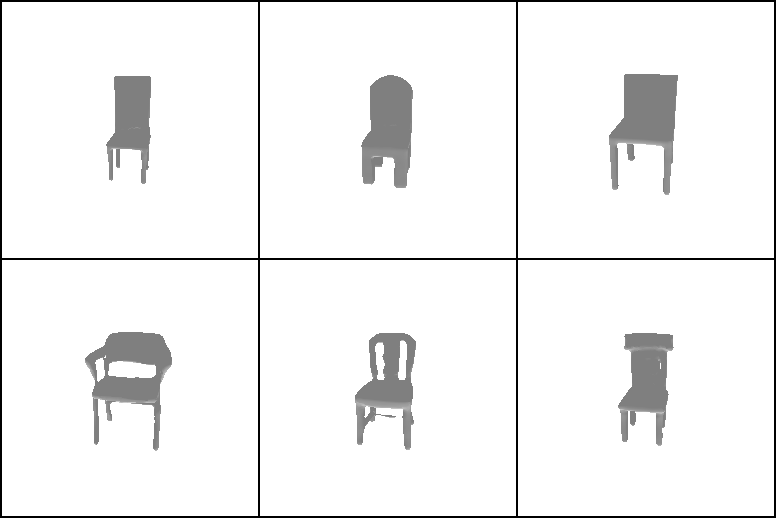

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: The seat has a space between the start of the seat and the start of the back itself
Full Text: The seat has a space between the start of the seat and the start of the back itself
Saved: logs/comparison/v21/5-0-model_new-The seat has a space between the start of the seat and the start of the back itself.gif


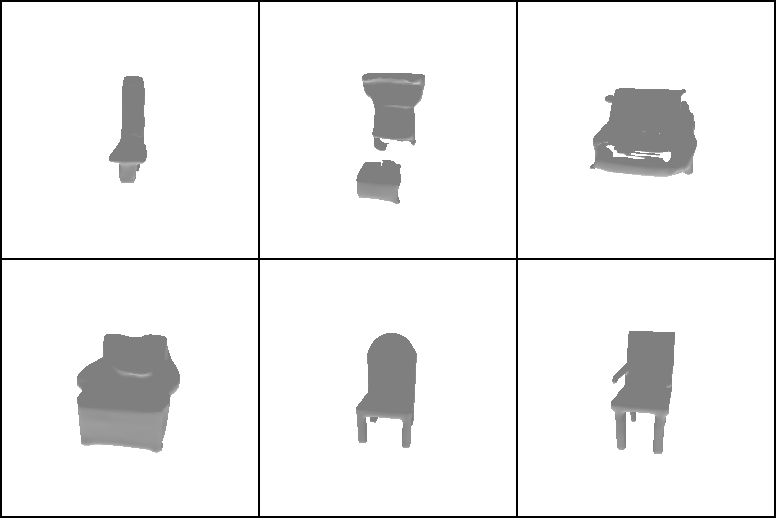

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: modern and legless black and has a wedged back
Full Text: The seat has a space between the start of the seat and the start of the back itself modern and legless black and has a wedged back
Saved: logs/comparison/v21/5-1-model_new-The seat has a space between the start of the seat and the start of the back itself modern and legless black and has a wedged back.gif


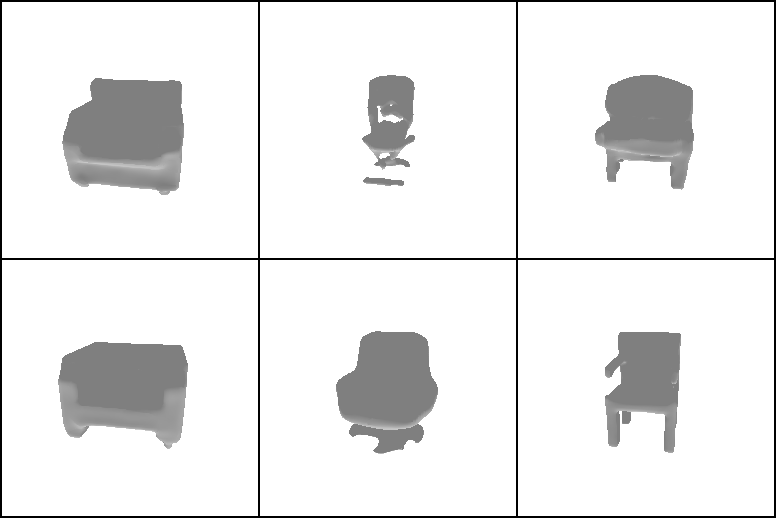

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT:  single pedestal and seems to float in the air
Full Text: modern and legless black and has a wedged back  single pedestal and seems to float in the air
Saved: logs/comparison/v21/5-2-model_new-modern and legless black and has a wedged back  single pedestal and seems to float in the air.gif


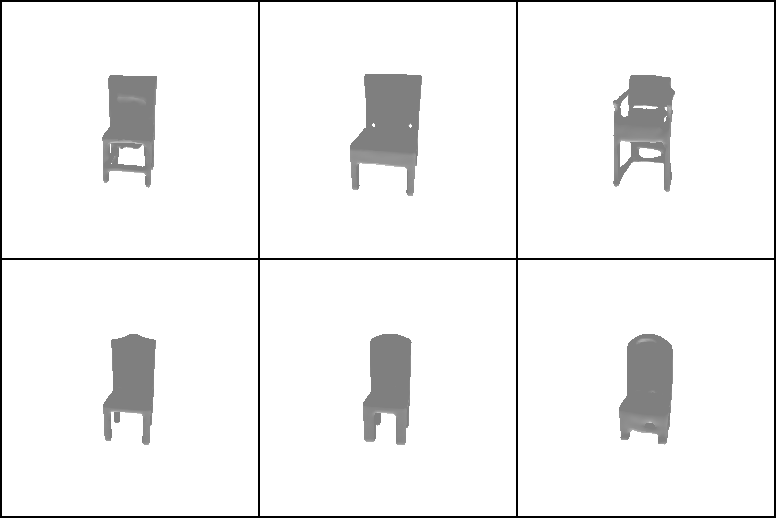

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: the back
Full Text: the back
Saved: logs/comparison/v21/6-0-model_new-the back.gif


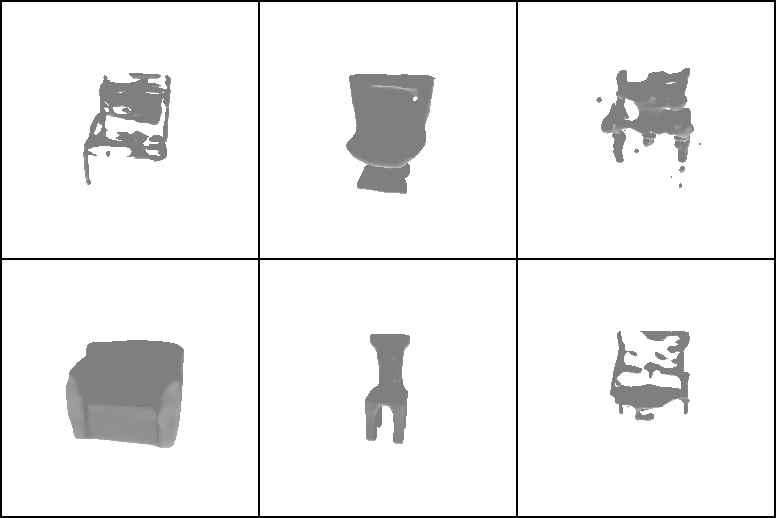

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: is rectrancle shaped
Full Text: the back is rectrancle shaped
Saved: logs/comparison/v21/6-1-model_new-the back is rectrancle shaped.gif


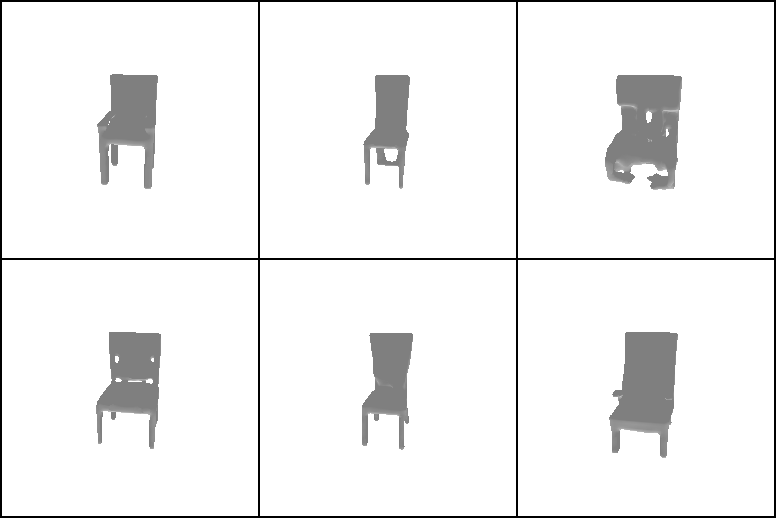

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: while the hand rests are cylindrical in shape
Full Text: is rectrancle shaped while the hand rests are cylindrical in shape
Saved: logs/comparison/v21/6-2-model_new-is rectrancle shaped while the hand rests are cylindrical in shape.gif


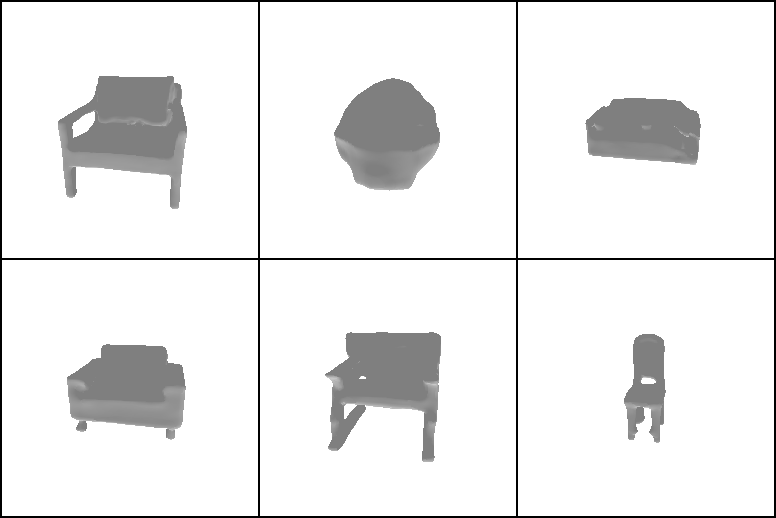

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: A cushion chair with ash colour
Full Text: while the hand rests are cylindrical in shape A cushion chair with ash colour
Saved: logs/comparison/v21/6-3-model_new-while the hand rests are cylindrical in shape A cushion chair with ash colour.gif


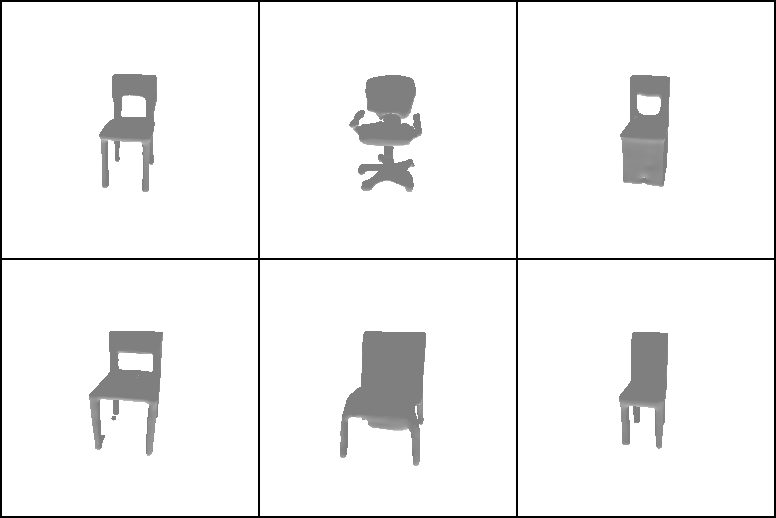

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: An orange fabric streteched deck chair
Full Text: An orange fabric streteched deck chair
Saved: logs/comparison/v21/7-0-model_new-An orange fabric streteched deck chair.gif


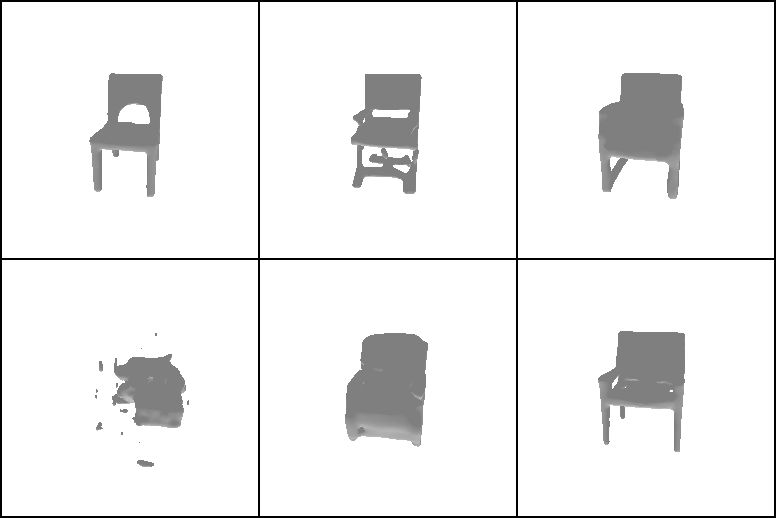

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: with an s shaped aluminum framing for support
Full Text: An orange fabric streteched deck chair with an s shaped aluminum framing for support
Saved: logs/comparison/v21/7-1-model_new-An orange fabric streteched deck chair with an s shaped aluminum framing for support.gif


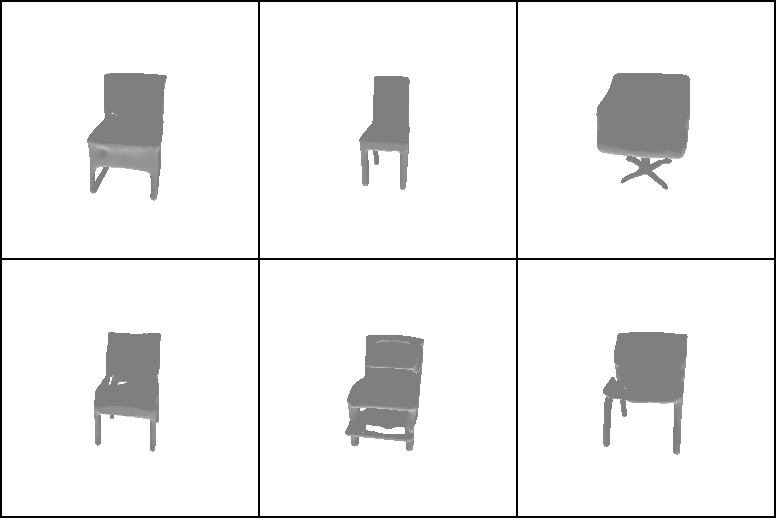

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([6, 8, 8, 8])
TEXT: the chair has short legs
Full Text: the chair has short legs
Saved: logs/comparison/v21/8-0-model_new-the chair has short legs.gif


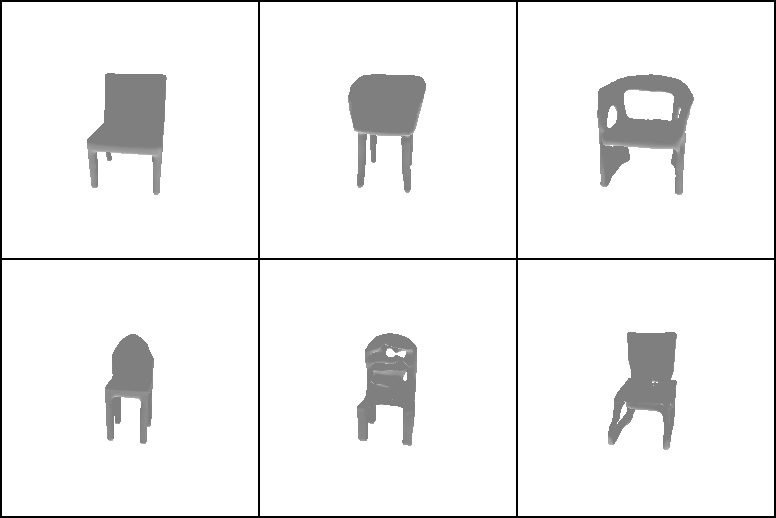

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

In [ ]:
model = modelNew
model_name = "model_new"

import torch
from utils.qual_util import get_lang_prob_recursive, save_mesh_as_pics
from einops import rearrange




for j in tqdm(range(len(sequences_clean))):
    #text = sequence[j]
    sequence = sequences_clean[j]
    last_text = ""
    z1 = torch.full((1,8,8,8,512), 1/512).cuda()
    test_data = { }
    sampler = torch.distributions.categorical.Categorical(z1)
    codeix = sampler.sample()
    
    
    test_data["z_set"] = z1.repeat_interleave(nimgs, dim=0)
    #test_data["z_set"] = shapeset[4]["z_set"].unsqueeze(0).repeat_interleave(nimgs, dim=0)
   
    test_data["idx"] = sampler.sample().repeat_interleave(nimgs, axis=0).cpu()
    test_data["z_q"] = z1
    print("======================================================================================================")
    for i in range(len(sequence)):
        text = sequence[i]
        all_text = last_text + text
        text_conditional = text
        lang_conditional_prob = get_lang_prob_recursive(bert2vq, all_text, z1)
        z1_old = rearrange(z1, 'bs d h w c -> (d h w bs) c')
        z1 = rearrange(lang_conditional_prob, '(d h w) bs c -> bs d h w c', d=8, h=8, w=8)
        gen_order = torch.argsort((torch.abs(lang_conditional_prob[:, 0, :]-z1_old)).sum(-1), dim=-1, descending=True)
        lang_conditional_prob = lang_conditional_prob.repeat(1, nimgs, 1)
        topk = 50
        # This should be replaced by bert output
#         if(i==2):
#             import pdb;pdb.set_trace()
        test_data["z_set"] = z1.repeat_interleave(nimgs, dim=0)
        model.inference(test_data, topk=topk, alpha=1, prob=None,gen_order=None)
        #test_data["z_set"] = z1.repeat_interleave(nimgs, dim=0)
        sampler = torch.distributions.categorical.Categorical(z1)
        test_data["idx"] = torch.cat( [sampler.sample().cpu() for i in range(6)], dim=0)
        print(test_data["idx"].shape)
        gen_mesh = sdf_to_mesh(model.x_recon_tf)
    
        gen_gif_name = f'{res_dir}/{j}-{i}-{model_name}-{all_text}.gif'
        #import pdb;pdb.set_trace()
        try:
            save_mesh_as_pics(mesh_renderer, gen_mesh, nrow=3, out_name=gen_gif_name)
        except:
            import pdb;pdb.set_trace()
        last_text = text_conditional + " "
        
        print("TEXT:", text_conditional)
        print("Full Text:", all_text)
        print("Saved:", gen_gif_name)
        for name in [gen_gif_name]:
            display(ipy_image(name))